# Thuật toán Di truyền

Notebook này là một phần của [Chương trình học AI dành cho người mới bắt đầu](http://github.com/microsoft/ai-for-beginners).


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Một số lý thuyết

**Thuật toán di truyền** (GA) dựa trên **phương pháp tiếp cận tiến hóa** trong AI, trong đó các phương pháp tiến hóa của quần thể được sử dụng để tìm ra giải pháp tối ưu cho một vấn đề cụ thể. Thuật toán này được đề xuất vào năm 1975 bởi [John Henry Holland](https://en.wikipedia.org/wiki/John_Henry_Holland).

Thuật toán di truyền dựa trên các ý tưởng sau:
* Các giải pháp hợp lệ cho vấn đề có thể được biểu diễn dưới dạng **gen**
* **Lai ghép** cho phép chúng ta kết hợp hai giải pháp lại với nhau để tạo ra một giải pháp mới hợp lệ
* **Chọn lọc** được sử dụng để chọn các giải pháp tối ưu hơn bằng cách sử dụng một **hàm đánh giá**
* **Đột biến** được giới thiệu để làm mất ổn định quá trình tối ưu hóa và giúp thoát khỏi cực tiểu cục bộ

Nếu bạn muốn triển khai một thuật toán di truyền, bạn cần:

 * Tìm một phương pháp mã hóa các giải pháp của vấn đề bằng **gen** $g\in\Gamma$
 * Trên tập hợp các gen $\Gamma$, cần định nghĩa **hàm đánh giá** $\mathrm{fit}: \Gamma\to\mathbb{R}$. Các giá trị hàm nhỏ hơn sẽ tương ứng với các giải pháp tốt hơn.
 * Định nghĩa cơ chế **lai ghép** để kết hợp hai gen lại với nhau nhằm tạo ra một giải pháp mới hợp lệ $\mathrm{crossover}: \Gamma^2\to\Gamma$.
 * Định nghĩa cơ chế **đột biến** $\mathrm{mutate}: \Gamma\to\Gamma$.
Trong nhiều trường hợp, lai ghép và đột biến là các thuật toán khá đơn giản để thao tác với gen dưới dạng chuỗi số hoặc vector bit.

Việc triển khai cụ thể một thuật toán di truyền có thể khác nhau tùy từng trường hợp, nhưng cấu trúc tổng quát như sau:

1. Chọn quần thể ban đầu $G\subset\Gamma$
2. Ngẫu nhiên chọn một trong các thao tác sẽ được thực hiện tại bước này: lai ghép hoặc đột biến 
3. **Lai ghép**:
  * Ngẫu nhiên chọn hai gen $g_1, g_2 \in G$
  * Tính toán lai ghép $g=\mathrm{crossover}(g_1,g_2)$
  * Nếu $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ hoặc $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ - thay thế gen tương ứng trong quần thể bằng $g$.
4. **Đột biến** - chọn ngẫu nhiên một gen $g\in G$ và thay thế nó bằng $\mathrm{mutate}(g)$
5. Lặp lại từ bước 2, cho đến khi đạt được giá trị đủ nhỏ của $\mathrm{fit}$, hoặc cho đến khi đạt giới hạn về số bước.

Các nhiệm vụ thường được giải quyết bằng GA:
1. Tối ưu hóa lịch trình
1. Tối ưu hóa đóng gói
1. Tối ưu hóa cắt
1. Tăng tốc tìm kiếm toàn diện


## Vấn đề 1: Chia Kho Báu Công Bằng

**Nhiệm vụ**:  
Hai người tìm thấy một kho báu chứa các viên kim cương có kích thước khác nhau (và tương ứng, giá trị khác nhau). Họ cần chia kho báu thành hai phần sao cho sự chênh lệch về giá trị là 0 (hoặc nhỏ nhất có thể).

**Định nghĩa chính thức**:  
Chúng ta có một tập hợp các số $S$. Cần chia nó thành hai tập con $S_1$ và $S_2$, sao cho $$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$ và $S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$.

Trước tiên, hãy định nghĩa tập hợp $S$:


In [3]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[8344 2197 9335 3131 5863 9429 3818 9791   15 5455 1396 9538 4872 6549
 8587 5986 6021 9764 8102 5083 5739 7684 8498 3007 6599  820 7490 2372
 9370 5235 3525 3154  859 1906 8159 3950 2173 2988 2050  349 8713 2284
 4177 6033 1651 9176 5049 8201  171 5081 1216 3756 4711 2757 7738 1272
 5650 6584 5395 9004 7797  969 8104 1283 1392 4001 5768  445  274  256
 8239 8015 4381 9021 1189 8879 1411 3539 6526 8011  136 7230 2332  451
 5702 2989 4320 2446 9578 8486 4027 2410 9588 8981 2177 1493 3232 9151
 4835 5594 6859 8394  369 3200  126 4259 2283 7755 2014 2458 8327 8082
 7413 7622 1206 5533 8751 3495 5868 8472 6850 3958 3149 4672 4810 6274
 4700 6134 4627 4616 6656 9949  884 2256 7419 1926 7973 5319 5967 9158
 3823 7697 9466 5675 5412 9784 5426 8209 3421 1136 6047 4429 8001 4417
 1381  722 7350 6018 6235 7860 5853 7660 5937 6242    1 9552 3971 8302
 2633 9227 7283  154 8599 4269 9392 8539 1630  368 2409 9351 3838 9814
 6186 5743 5083 1325 1610  779 3643 3262 5768 8725  961 4611 6310 4788
 1648 

Hãy mã hóa mỗi giải pháp có thể của vấn đề bằng một vector nhị phân $B\in\{0,1\}^N$, trong đó số ở vị trí thứ $i$ cho biết số thứ $i$ trong tập ban đầu $S$ thuộc về tập nào ($S_1$ hoặc $S_2$). Hàm `generate` sẽ tạo ra các vector nhị phân ngẫu nhiên đó.


In [5]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 1 1
 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0
 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1
 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0]


Bây giờ hãy định nghĩa hàm `fit` để tính toán "chi phí" của giải pháp. Nó sẽ là sự khác biệt giữa tổng của hai tập hợp, $S_1$ và $S_2$:


In [6]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

133784

Bây giờ chúng ta cần định nghĩa các hàm cho đột biến và lai ghép:  
* Đối với đột biến, chúng ta sẽ chọn một bit ngẫu nhiên và đảo ngược nó (thay đổi từ 0 thành 1 và ngược lại).  
* Đối với lai ghép, chúng ta sẽ lấy một số bit từ một vector và một số bit từ vector khác. Chúng ta sẽ sử dụng cùng hàm `generate` để chọn ngẫu nhiên, bit nào sẽ được lấy từ mặt nạ đầu vào nào.  


In [7]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

Hãy tạo quần thể ban đầu của các nghiệm $P$ với kích thước `pop_size`:


In [8]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

Bây giờ, hàm chính để thực hiện quá trình tiến hóa. `n` là số bước tiến hóa cần thực hiện. Ở mỗi bước:
* Với xác suất 30%, chúng ta thực hiện một đột biến và thay thế phần tử có hàm `fit` kém nhất bằng phần tử đã được đột biến
* Với xác suất 70%, chúng ta thực hiện lai ghép

Hàm trả về giải pháp tốt nhất (gene tương ứng với giải pháp tốt nhất) và lịch sử của giá trị nhỏ nhất của hàm fit trong quần thể ở mỗi lần lặp.


In [9]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[0 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1] 4


Bạn có thể thấy rằng chúng tôi đã giảm thiểu hàm `fit` khá nhiều! Đây là biểu đồ cho thấy cách hàm `fit` cho toàn bộ quần thể hoạt động trong quá trình này.


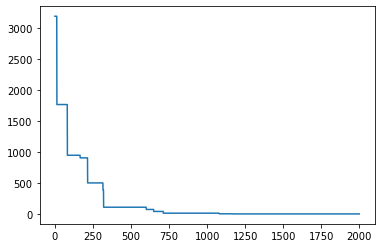

In [10]:
plt.plot(hist)
plt.show()

## Vấn đề 2: Bài toán N Hậu

**Nhiệm vụ**:  
Bạn cần đặt $N$ quân hậu trên bàn cờ kích thước $N\times N$ sao cho chúng không tấn công lẫn nhau.

Trước tiên, hãy giải quyết vấn đề này mà không sử dụng thuật toán di truyền, bằng cách tìm kiếm toàn diện. Chúng ta có thể biểu diễn trạng thái của bàn cờ bằng danh sách $L$, trong đó số thứ $i$ trong danh sách là vị trí ngang của quân hậu ở hàng thứ $i$. Rõ ràng rằng mỗi giải pháp sẽ chỉ có một quân hậu trên mỗi hàng, và mỗi hàng sẽ có một quân hậu.

Mục tiêu của chúng ta là tìm giải pháp đầu tiên cho vấn đề, sau đó dừng việc tìm kiếm. Bạn có thể dễ dàng mở rộng hàm này để tạo ra tất cả các vị trí có thể cho các quân hậu.


In [11]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False
            
nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

Bây giờ hãy đo xem mất bao lâu để tìm được lời giải cho bài toán 20 quân hậu:


In [12]:
%timeit nqueens([],20,False)

10.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Bây giờ, chúng ta sẽ giải quyết vấn đề này bằng cách sử dụng thuật toán di truyền. Giải pháp này được lấy cảm hứng từ [bài viết trên blog này](https://kushalvyas.github.io/gen_8Q.html).

Chúng ta sẽ biểu diễn mỗi giải pháp bằng cùng một danh sách có độ dài $N$, và như một hàm `fit`, chúng ta sẽ tính số lượng quân hậu tấn công lẫn nhau:


In [13]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

Vì việc tính toán hàm thích nghi tốn nhiều thời gian, hãy lưu trữ mỗi giải pháp trong quần thể cùng với giá trị của hàm thích nghi. Hãy tạo quần thể ban đầu:


In [14]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([2, 3, 8, 7, 5, 4, 1, 6]), 4),
 (array([3, 4, 5, 1, 2, 8, 6, 7]), 8),
 (array([1, 3, 7, 4, 5, 8, 6, 2]), 6),
 (array([1, 5, 4, 6, 8, 3, 7, 2]), 4),
 (array([3, 5, 7, 1, 8, 6, 4, 2]), 3)]

Bây giờ chúng ta cần định nghĩa các hàm đột biến và lai ghép. Lai ghép sẽ kết hợp hai gen lại với nhau bằng cách chia chúng tại một điểm ngẫu nhiên và nối hai phần từ các gen khác nhau lại với nhau.


In [15]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G
    
def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 2, 7, 8])

In [17]:
def choose_rand(P):
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N=len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

Bây giờ, chúng ta sẽ định nghĩa vòng lặp tiến hóa chính. Chúng ta sẽ làm cho logic hơi khác so với ví dụ trước để cho thấy rằng bạn có thể sáng tạo. Chúng ta sẽ lặp lại cho đến khi đạt được giải pháp hoàn hảo (hàm fitness = 0), và ở mỗi bước, chúng ta sẽ lấy thế hệ hiện tại và tạo ra thế hệ mới có cùng kích thước. Điều này được thực hiện bằng hàm `nxgeneration`, theo các bước sau:

1. Loại bỏ các giải pháp kém phù hợp nhất - có hàm `discard_unfit` để thực hiện việc này
2. Thêm một số giải pháp ngẫu nhiên vào thế hệ
3. Tạo thế hệ mới có kích thước `gen_size` bằng cách thực hiện các bước sau cho mỗi gene mới:
    - chọn hai gene ngẫu nhiên, với xác suất tỷ lệ thuận với hàm fitness
    - tính toán một phép lai (crossover)
    - áp dụng một đột biến với xác suất `mutation_prob`


In [20]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen
    
def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([4, 7, 5, 3, 1, 6, 8, 2]), 0)

Thật thú vị rằng hầu hết các lần chúng ta có thể tìm được giải pháp khá nhanh chóng, nhưng trong một số trường hợp hiếm hoi, tối ưu hóa đạt đến cực tiểu cục bộ và quá trình bị mắc kẹt trong thời gian dài. Điều quan trọng là phải tính đến điều đó khi bạn đo thời gian trung bình: mặc dù trong hầu hết các trường hợp thuật toán di truyền sẽ nhanh hơn tìm kiếm toàn diện, nhưng trong một số trường hợp nó có thể mất nhiều thời gian hơn. Để khắc phục vấn đề này, thường có ý nghĩa khi giới hạn số thế hệ cần xem xét, và nếu chúng ta không thể tìm được giải pháp - chúng ta có thể bắt đầu lại từ đầu.


In [19]:
%timeit genetic(10)

The slowest run took 18.71 times longer than the fastest. This could mean that an intermediate result is being cached.
26.4 s ± 28.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



---

**Tuyên bố miễn trừ trách nhiệm**:  
Tài liệu này đã được dịch bằng dịch vụ dịch thuật AI [Co-op Translator](https://github.com/Azure/co-op-translator). Mặc dù chúng tôi cố gắng đảm bảo độ chính xác, xin lưu ý rằng các bản dịch tự động có thể chứa lỗi hoặc không chính xác. Tài liệu gốc bằng ngôn ngữ bản địa nên được coi là nguồn thông tin chính thức. Đối với các thông tin quan trọng, khuyến nghị sử dụng dịch vụ dịch thuật chuyên nghiệp từ con người. Chúng tôi không chịu trách nhiệm cho bất kỳ sự hiểu lầm hoặc diễn giải sai nào phát sinh từ việc sử dụng bản dịch này.
